# (Try to) identify signals of gentrification from Airbnb data

In [1]:
import os
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from datetime import datetime
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
from IPython.core.pylabtools import figsize
from fontTools.varLib.interpolatableHelpers import matching_for_vectors
import folium
import branca.colormap as cm
from sklearn.preprocessing import StandardScaler
import sys
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.cm import ScalarMappable

sys.path.insert(0, '../')
from PlottingFunctions import *

cmap = plt.get_cmap('viridis', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

city='manchester'

### Get just Manchester LSOAs

In [2]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

In [3]:
manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]
central_lsoas.reset_index(inplace=True)

## Get gentrification scores for each listing

In [5]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_one_per_lsoa_10.csv')

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction'].map(mapping)
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction_code'].astype(int)
score_per_listing.head()

,Unnamed: 0,LSOA11NM,text,gentrification_prediction,explanation,gentrification_prediction_code
0,0,Bury 023C,2 minutes walk from the entrance to Heaton Par...,Established,The neighborhood is presented as having existi...,4
1,1,Bury 023D,Presenting Prestwich Apartments! Welcome to ou...,Established,"The neighborhood is described as friendly, wel...",4
2,2,Bury 023E,This is a newly refurbished luxury house with ...,Gentrifying,The neighborhood overview highlights Prestwich...,3
3,3,Bury 024B,"Lovely double glazed 2 bed, 1 bath flat locate...",Gentrifying,The neighborhood overview highlights Prestwich...,3
4,4,Bury 024C,1 double bedroom and conservatory annex with b...,Established,The neighborhood is described as a quiet resid...,4


## Join to spatial information

In [9]:
score_per_listing_gdf = central_lsoas[['LSOA11NM', 'geometry']].merge(score_per_listing, on='LSOA11NM')

### Check this spatially

In [10]:
colors = [cmap(i) for i in range(5)]
color_map = dict(zip(range(5), colors))
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)

## Plot

<Axes: >

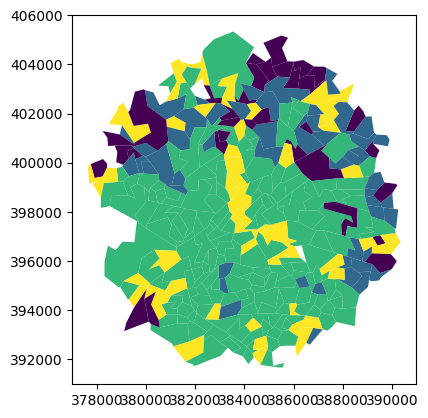

In [15]:
score_per_listing_gdf.plot('gentrification_prediction_code')